In [1]:
import numpy as np
from sklearn import svm
import seaborn as sns
from matplotlib import pyplot as plt

# Gruppenmitglieder Lukas Hein, Jan Neitzner, Timo Matzok, Yannick Buchmeier
# Die Installation der bayesian-optimization 
# könnte für Sie erforderlich sein!
#!pip install bayesian-optimization

# 1 Business Understanding

Der Datensatz unserer Challenge befasst sich mit der Analyse und dem Vorhersagen von Herzinfarkten. Durch die Analyse von verschiedenen Patientendaten soll frühzeitig ein hohes Herzinfarktrisiko vorhergesagt werden. Dadurch kann rechtzeitig mit einer Behandlung zur Prävention begonnen werden. 

Kein besonderer Fokus wurde auf die benötigten Ressourcen der künstlichen Intelligenz gelegt. Dies liegt daran, dass ein Menschenleben nicht mit den Ressourcen abzuwiegen ist. Aus diesem Grund geht ebenfalls heraus, dass jedes Prozent der Genauigkeit wichtig ist. Außerdem ist kein besonders hoher Wert auf die Performance der Durchlaufzeit oder ähnlichen Werten gelegt. Aus Darstellungsgründen wurden jedoch an einigen Stellen Annahmen und Vereinfachungen eingebaut.

Ein besonderer Fokus der Berechnung soll darauf liegen, dass möglichst wenige Herzinfarkte unentdeckt bleiben. 

# 2 Data Understanding


## 2.1 Collect Initial Data

Link zum Datensatz: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [2]:
import pandas as pd
# Datenset laden
fulldata = pd.read_csv("heart.csv")

## 2.2 Describe Data

In [3]:
fulldata

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
fulldata.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

Folgende Variablenerklärungen liefert der Datensatz

|Variable|Erklärung|Anmerkung|
|:---|:---|:---|
age|Age of the patient|
sex|Sex of the patient|keine Erklärung, welches Geschlecht wie kodiert ist
cp|Chest Pain type chest pain type|Value 1: typical angina<br>Value 2: atypical angina<br>Value 3: non-anginal pain<br>Value 4: asymptomatic
trtbps|resting blood pressure (in mm Hg)|Ruheblutdruck
chol|cholestoral in mg/dl fetched via BMI sensor|Cholesterinspiegel
fbs|(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)|Erhöhter Blutzucker
restecg|resting electrocardiographic results|Value 0: normal<br>Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)<br>Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalachh|maximum heart rate achieved|Maximaler Puls
exng|exercise induced angina (1 = yes; 0 = no)|Engegefühl in der Brust bei körperlicher Belastung
oldpeak|keine Erklärung vorhanden|
slp|keine Erklärung vorhanden|
caa|number of major vessels (0-3)|weglassen, da Beschreibung uneindeutig, Skala passt auch nicht [0-3] 
thall|keine Erklärung vorhanden|
output|0 = less chance of heart attack<br> 1 = higher chance of heart attack

Für die Spalten ``oldpeak``, ``slp`` und ``thall`` existieren keine Erklärungen.

In [5]:
fulldata.thall.unique()

array([1, 2, 3, 0], dtype=int64)

Nach weiterer Recherche können folgende Vermutungen aufgestellt werden. 

Die Spalte ``thall`` bezieht sich auf die Form der Thalssämie. Dabei stehen die Werte 1-3 für die Art der Krankheit, wohingegen die 0 kein Vorhandensein der Krankheit abbildet.  <br> 
<a href="https://www.netdoktor.de/krankheiten/thalassaemie/#:~:text=Die%20Thalass%C3%A4mie%20oder%20Mittelmeeran%C3%A4mie%20ist,Alpha%2D%20und%20Beta%2DThalass%C3%A4mie.">Quelle 1</a>
<br>
<a href="https://www.kinderblutkrankheiten.de/erkrankungen/rote_blutzellen/anaemien_blutarmut/thalassaemie/krankheitsformen/">Quelle 2</a> <br>

In [6]:
fulldata.slp.unique()

array([0, 2, 1], dtype=int64)

Die Spalte ``slp`` ist die Abkürzung für Slope. Dieser Wert wird beim Auswerten eines EKGs benutzt (<a href="https://pubmed.ncbi.nlm.nih.gov/18269981/">Quelle</a>). Die genaue Kodierung der Daten ist unbekannt.

In [7]:
fulldata.oldpeak.unique()

array([2.3, 3.5, 1.4, 0.8, 0.6, 0.4, 1.3, 0. , 0.5, 1.6, 1.2, 0.2, 1.8,
       1. , 2.6, 1.5, 3. , 2.4, 0.1, 1.9, 4.2, 1.1, 2. , 0.7, 0.3, 0.9,
       3.6, 3.1, 3.2, 2.5, 2.2, 2.8, 3.4, 6.2, 4. , 5.6, 2.9, 2.1, 3.8,
       4.4])

Für die Spalte ``oldpeak`` wurde keine Erklärung gefunden, scheint jedoch nach Rücksprache mit einer Medizinerin relevant.

## 2.3 Explore Data

In [8]:
fulldata.isnull().sum()
#keine fehlenden Daten vorhanden

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [9]:
fulldata.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Der Anteil zu gefährdeten und nicht gefährdeten Personen liegt bei circa 50%.

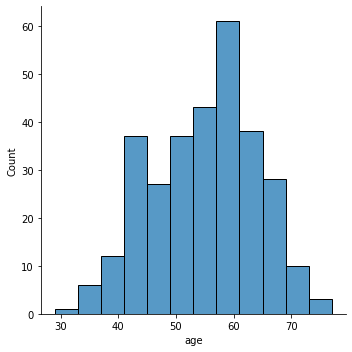

In [10]:
sns.displot(fulldata['age']);

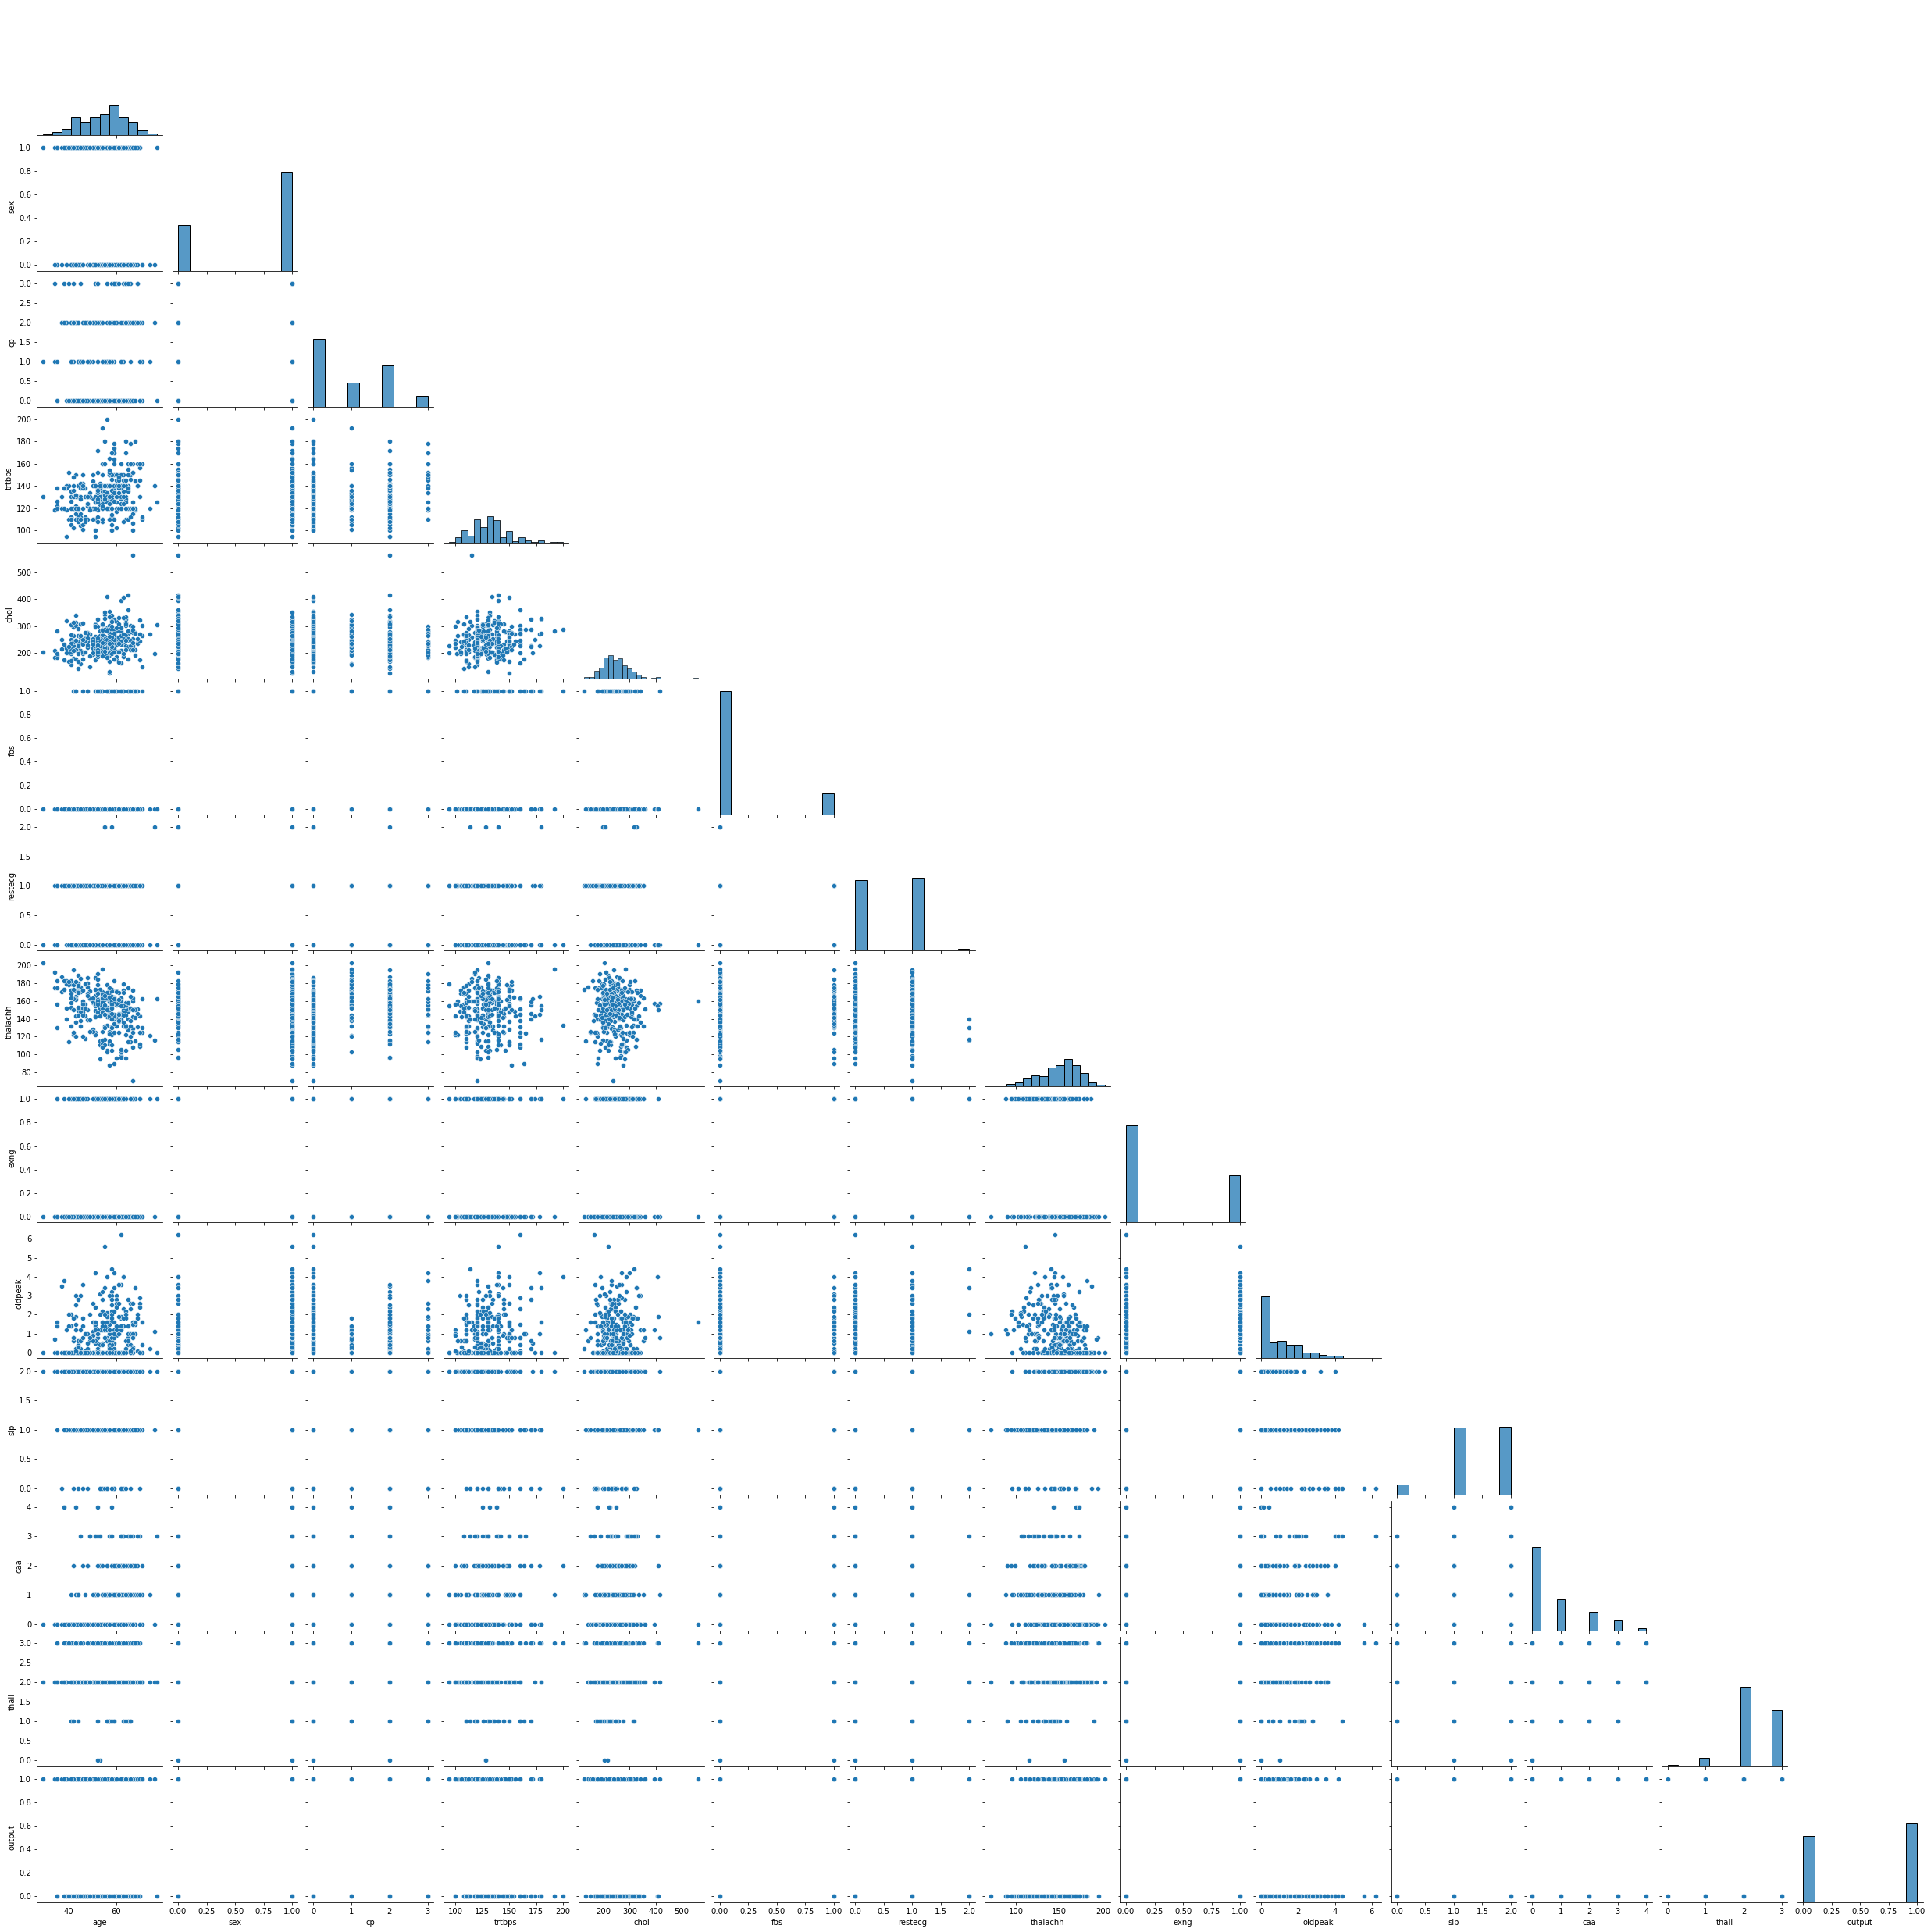

In [11]:
_ = sns.pairplot(fulldata, corner=True)

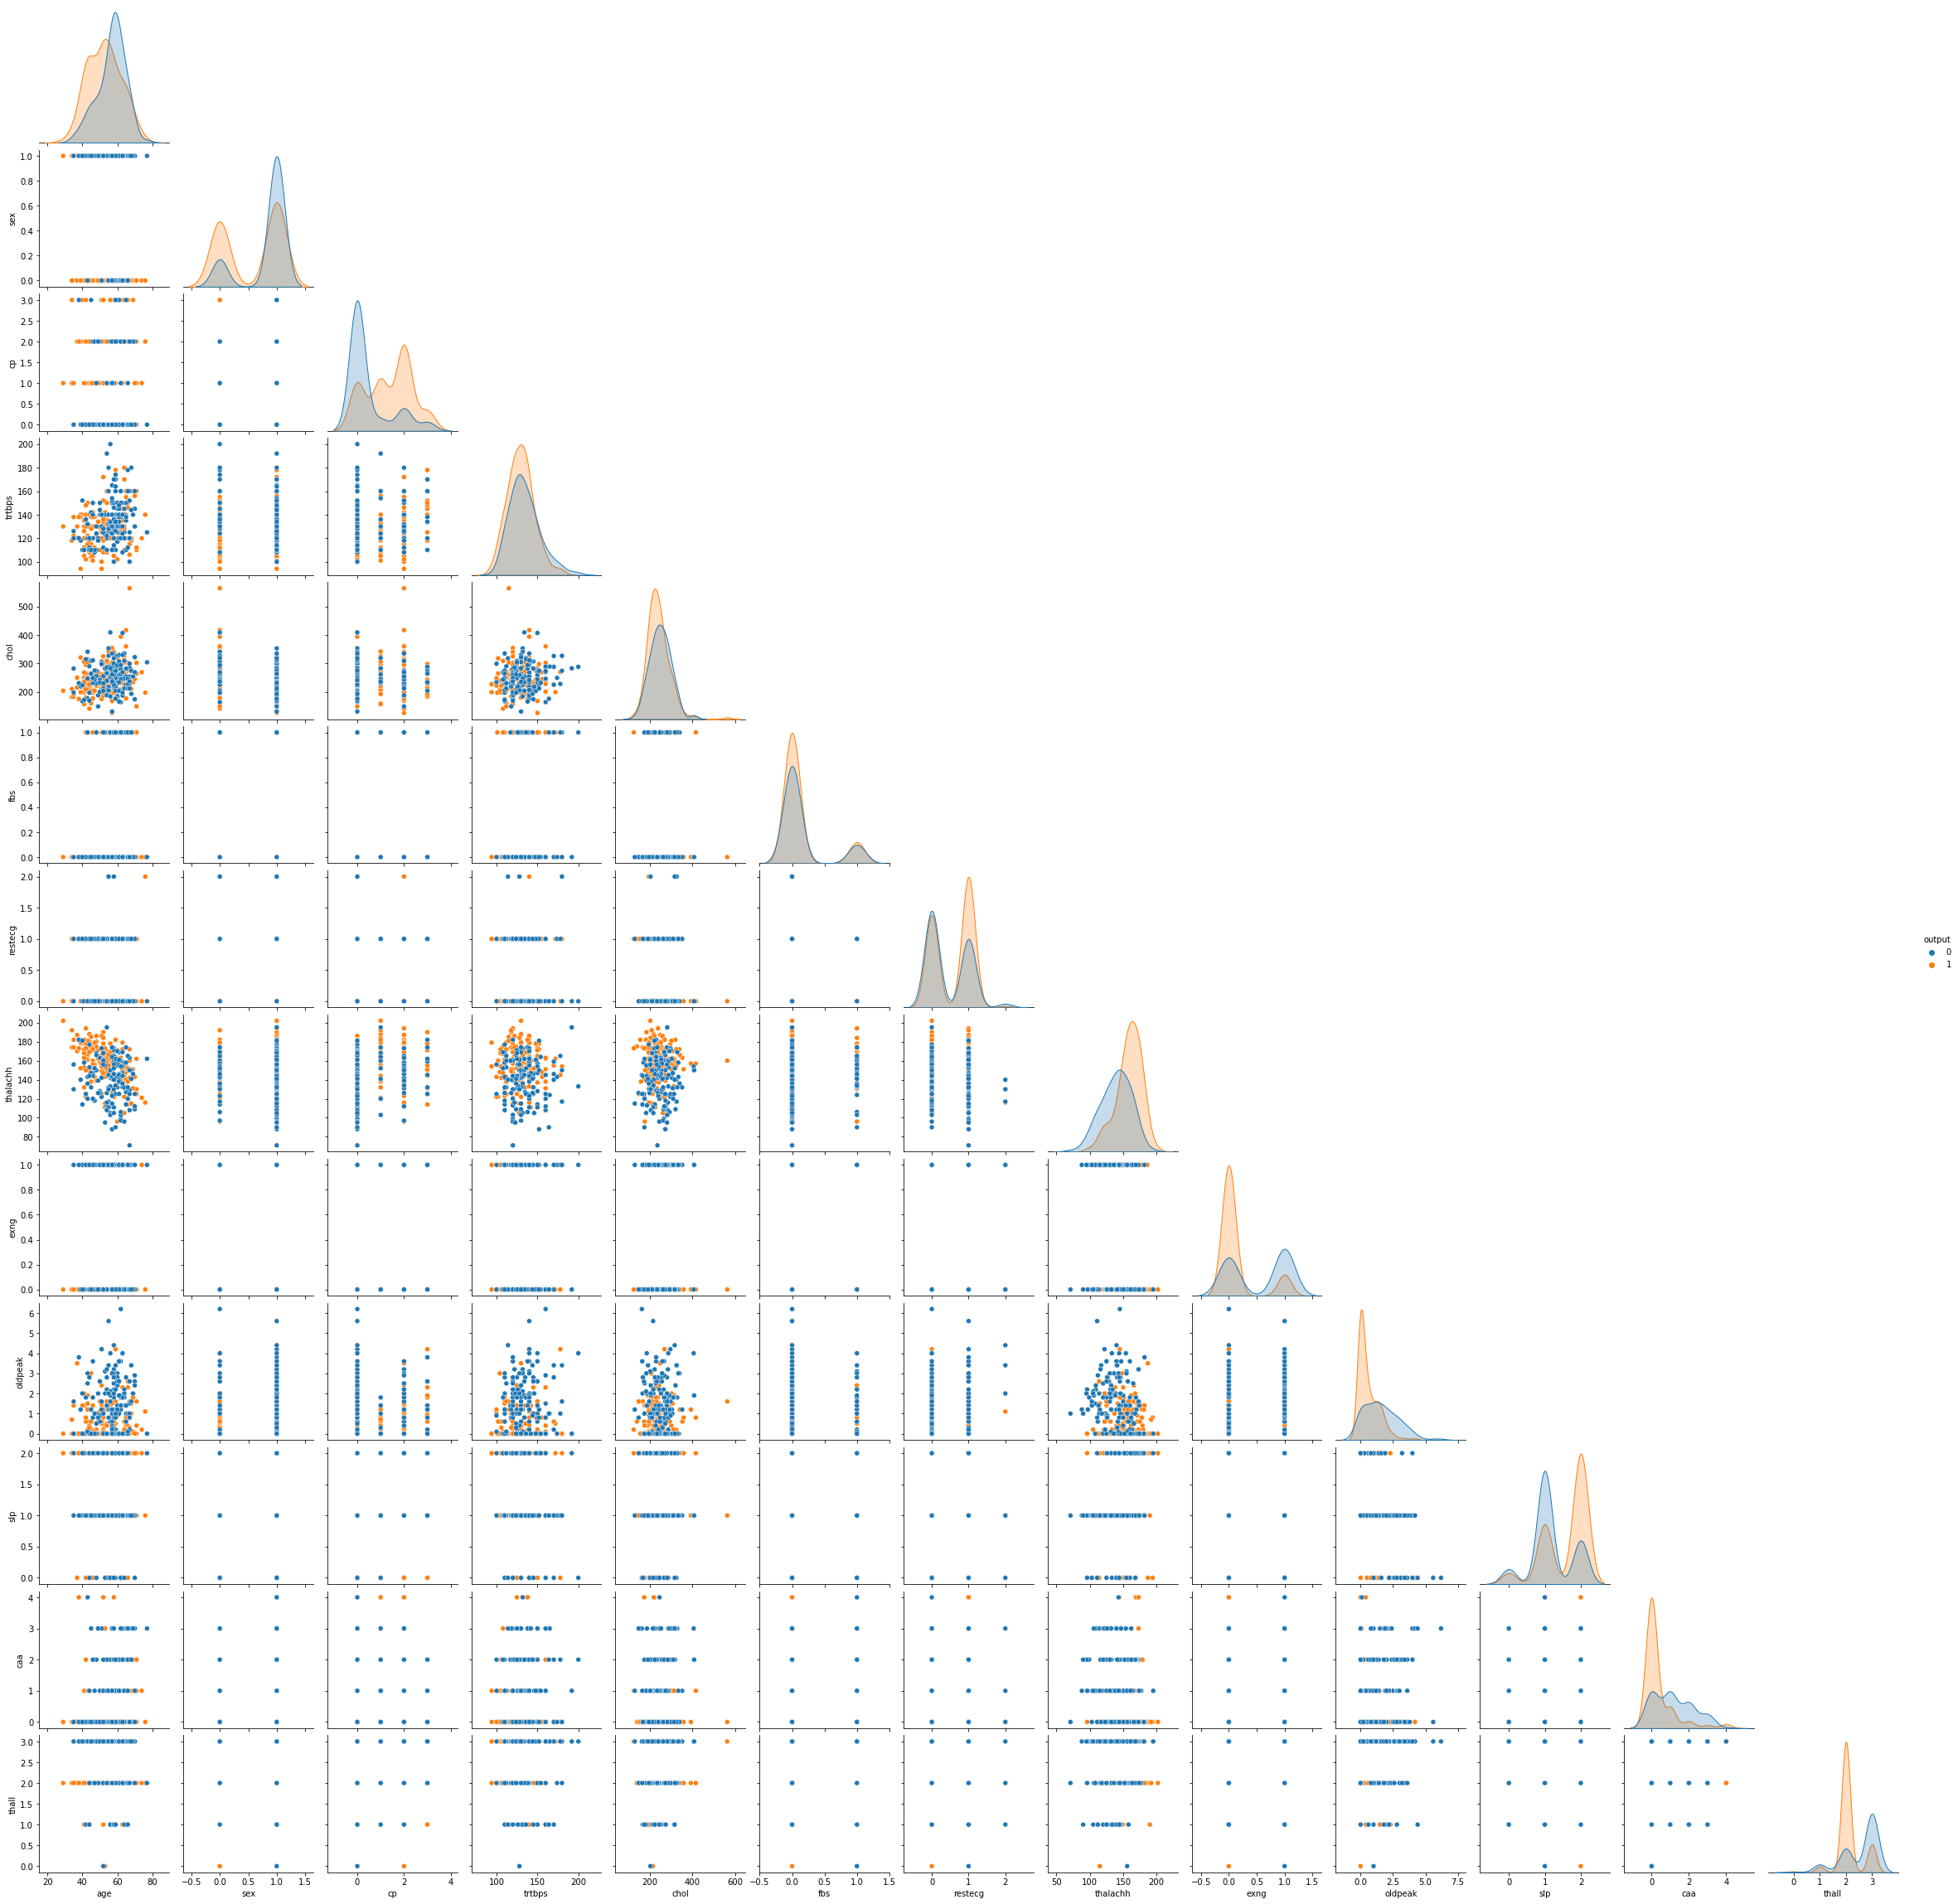

In [12]:
_ = sns.pairplot(fulldata, hue="output", corner=True)

Durch die beiden Pairplots sind keine einfachen Korrelationen der Variablen ersichtlich.

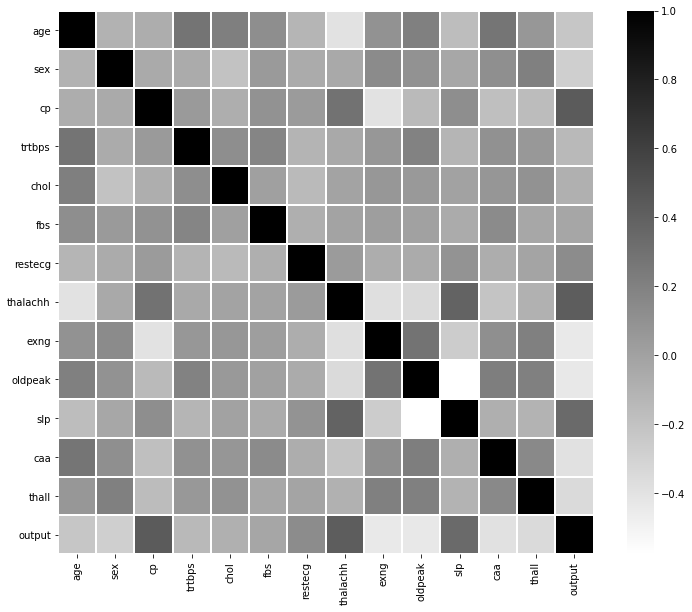

In [13]:
#correlation matrix
corrmat = fulldata.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, cmap="binary", linewidths=1);

In [14]:
corrmat.max()

age         1.0
sex         1.0
cp          1.0
trtbps      1.0
chol        1.0
fbs         1.0
restecg     1.0
thalachh    1.0
exng        1.0
oldpeak     1.0
slp         1.0
caa         1.0
thall       1.0
output      1.0
dtype: float64

Auch durch weitere Berechnung wird keine deutliche Korrelation zweier Variablen deutlich.

# 3 Data Preparation

## 3.1 Select Data

Innerhalb des Data Understandings sind unerklärte Spalten entdeckt worden. Da der Datensatz in sich geschlossen ist und keine willkürlichen Daten beinhaltet, können die Daten weiter benutzt werden. Hierdurch wird die Anzahl der verfügbaren Daten möglichst hoch gehalten. In einer realen Anwendung des Algorithmus muss das Data Understanding mit weiterem Fachwissen durchgeführt werden, um die Daten besser zu analysieren und hierdurch bessere Ergebnisse zu berechnen. In unserem Fall wurde Absprache mit einer Medizinstudentin durchgeführt. Hierdurch wurde die Aussagekraft der Daten bestätigt.

## 3.2 Data Cleaning

Da mit einem sauberen Datensatz begonnen wird ist eine separate Datenbereinigung nicht notwendig. 

## 3.3 Construct Data

Es werden keine zusätzlichen Berechnungen zur Generierung weiterer Daten durchgeführt.

## 3.4 Integrate Data

Es werden keine weiteren Daten hinzugefügt.

## 3.5 Format Data

In [15]:
# Datentypen anpassen

#Folgende Werte sind kategorisch, werden bisher im Datensatz jedoch numerisch dargestellt

cols = [
    "sex",
    "cp",
    "restecg",
    "slp",
    "caa",
    "thall"
]

for col in cols:
    fulldata[col] = fulldata[col].astype("category")

#Folgende Werte sind boolisch, werden bisher im Datensatz jedoch numerisch dargestellt
    
cols = [
    "fbs",
    "exng",
     "output"
]

for col in cols:
    fulldata[col] = fulldata[col].astype("bool")

In [16]:
#Trennung von Daten und Label

data = fulldata.drop(['output'], axis=1)

output = fulldata['output']

In [17]:
from sklearn.model_selection import train_test_split

# load data
X, y = data, output

# split the data into 2 sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(227, 13) (227,)
(76, 13) (76,)


# 4 Modeling
Im folgenden soll das Modell unter Berücksichtigung der Hyperparameter-Optimierung erstellt, trainiert und getestet werden. 
Wir haben uns dabei an der Map von Scikit-Learn orientiert und sind dementsprechend mit einer Support Vector Machine gestartet.
<img src="https://scikit-learn.org/stable/_static/ml_map.png">

Nachfolgend soll der bestmögliche Kernel für die Support Vector Machine selektiert werden. Dazu werden
alle im Paket enthaltenen Kernel anhand einer Kreuzvalidierung durchgetestet. dessen Mean der Accuracy wird dann ausgegeben,
wobei sich der lineare Kernel als bester Kernel für das Modell erwies. Der precomputed-Kernel wurde nicht getestet, da dieser sich nur auf eigens erstellte Kernel bezieht.

In [18]:
from sklearn.model_selection import cross_val_score
# Erstellung eines leeren Result-Arrays
result_array = []
# Auflistung der Kernel
methods = ["linear", "poly", "rbf", "sigmoid"]
k = 10
# Iteration durch die Kernel
for i, element in enumerate(methods):
    # Kreuzvalidierung
    method = methods[i] 
    clf = svm.SVC(kernel=method, C=1)
    scores = cross_val_score(clf, data, output, cv=k)
    # Füllung des Result-Arrays
    result_array.append((scores.mean(), method))
result_array

[(0.8348387096774192, 'linear'),
 (0.663763440860215, 'poly'),
 (0.6604301075268817, 'rbf'),
 (0.5411827956989248, 'sigmoid')]

Anschließend soll der Regularisierungsparameter 'C' optimiert werden. C Stellt die Größe der „Penalty“ für jede falsche Klassifizierung dar. Damit wird der Bias/Variance-Tradeoff ausbalanciert. Je höher C, desto höher die Penalty. Ein kleines C führt zu möglichst hohen Abständen (Margin) des Hyperplanes zu den Klassifikationen auf Kosten von mehr falschen Klassifizierungen. Ein hohes C ist „strenger“ und führt zu weniger Fehlklassifikationen auf Kosten des Abstands. Der C Wert liegt im Normalfall zwischen 0,1 und 100.
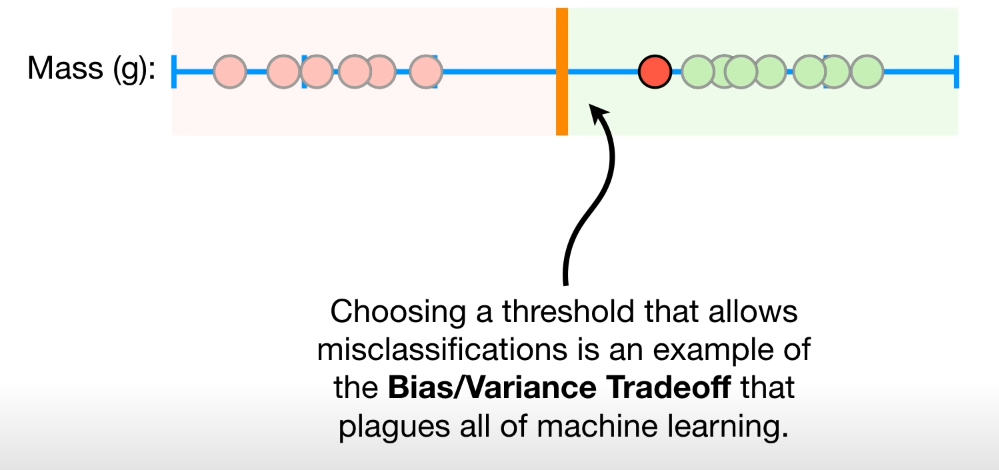

Wir beginnen mit einer einfach Grid-Search.

In [19]:

from sklearn.model_selection import GridSearchCV

# Definition der Parameter für die Grid-Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']}]


# Erstellung und Training der SVCs mit den oben definierten Parametern
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(data, output)

# Ausgabe des besten Schätzers
clf.best_estimator_

SVC(C=1, kernel='linear')

In [20]:
# Durchschnittliche Accuracy der Kreuzvaliderung mit C = 1
k = 10
clf = svm.SVC(kernel="linear", C=1)
scores = cross_val_score(clf, data, output, cv=k)
scores.mean()

0.8348387096774192

Die Grid-Search ist sehr ungenau. Sie prüft zwar einige Parameter ab, doch was ist wenn das Optimum
zwischen den Rasterpunkten liegt? Da es bei der Klassifikation eines Herzinfarktrisikos um Leben und Tod geht,
sollten die Ergebnisse allerdings möglichst akkurat sein. Deshalb wird im Folgenden eine genauere Optimierungsmethodik verwendet, die Bayesian Optimization. 
Dabei werden ein paar Testwerte von C genommen und mit dem mean einiger Gaussian Process Regressoren zu einer geschätzten Funktion verbunden. Die Acquisition Function wird dann mit 

$$
a(x) = f(x) + \kappa * \sigma(f(x))
$$

berechnet, wobei um die Punkte Konfidenzintervalle gezeichnet werden. Je größer dieses, desto unsicherer ist die Schätzung durch den Regressor. Anschließend wird das Maximum oder Minimum der unteren oder oberen Acquisition Funktion, je nach Anwendungsfall, ermittelt und dieser Datenpunkt als weiterer Input für die Black Box Funktion gesetzt. Die Methodik beginnt dann wieder von vorn und nach n Iterationen bekommen wir einen an das Optimum approximierten Datenpunkt 

<center><b>Ablauf der Bayesian Optimization</b></center>

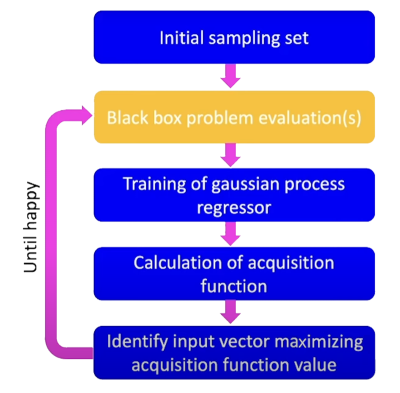

<center><b>Beispiel einer Bayesian Optimization</b></center>

![BayesUrl](https://upload.wikimedia.org/wikipedia/commons/0/02/GpParBayesAnimationSmall.gif)

<center><b>Bayesian Optimization dieser Arbeit</b></center>

In [21]:
#Import des Bayesian Optimization Modells
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Definition der zu optimierenden Blackbox-Funktion.

def black_box_function(C):
    # Zu optimieren ist vorerst die durchschnittliche Accuracy der Kreuzvalidierung mit variablem C-Wert
    k=10
    model = svm.SVC(kernel="linear", C=C)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, data, output, cv=k)
    f = scores.mean()
    return f

# Range, für welche C optimiert werden soll. die Werte unter 0 werden nicht genommen, da diese in einem Test im Vorfeld
# deutlich schlechtere Ergebnisse lieferten
# bayes_opt benötigt ein Dictionary.
pbounds = {"C": [1, 100]}
# Erstellung eines BayesianOptimization Optimizer,
# und Optimierung der gegebenen black_box_function.
optimizer_acc = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2
                                 )
optimizer_acc.maximize(init_points = 10, n_iter = 10)
# Ausgabe der Ergebnisse
print("Best result: {}; f(x) = {}.".format(optimizer_acc.max["params"], optimizer_acc.max["target"]))

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.8247   |  55.36    |
|  2        |  0.8415   |  79.74    |
|  3        |  0.8316   |  13.53    |
|  4        |  0.8313   |  54.5     |
|  5        |  0.8384   |  78.04    |
|  6        |  0.8313   |  60.77    |
|  7        |  0.8282   |  37.53    |
|  8        |  0.8216   |  55.28    |
|  9        |  0.8382   |  7.125    |
|  10       |  0.8282   |  48.48    |
|  11       |  0.8415   |  79.55    |
|  12       |  0.8283   |  68.62    |
|  13       |  0.8351   |  79.56    |
|  14       |  0.8351   |  79.74    |
|  15       |  0.8351   |  79.74    |
|  16       |  0.8248   |  47.04    |
|  17       |  0.8416   |  79.56    |
|  18       |  0.8248   |  23.02    |
|  19       |  0.8383   |  79.56    |
|  20       |  0.8382   |  79.55    |
Best result: {'C': 79.5563987218444}; f(x) = 0.8416129032258064.


Da der Optimizer bei jeder Iteration 10 Support Vector Machines trainiert, wurde die Anzahl der Iterationen zu Darstellungszwecken auf 20 herabgesetzt. Durch diesen Umstand und das Entfernen des random_state-Arguments kann es daher zu abweichenden Ergebnissen in der nachfolgenden Evaluation der Accuracy-Optimierung kommen. nach nicht allzu vielen Iterationen (in unserem Beispiel gelang es ab der 8. Iteration) sollte allerdings eine Accuracy, besser als die der Grid-Search, durch einen optimierten C-Parameter erzielt werden. 

In [22]:
# Neue Accuracy mit angepasstem C-Wert
k=10
model = svm.SVC(kernel="linear", C=optimizer_acc.max["params"].get("C"))
model.fit(X_train, y_train)
scores = cross_val_score(model, data, output, cv=k)
scores.mean()

0.8416129032258064

In [23]:
# Accuracy mit C=1 aus der Grid-Search 
k=10
testmodel = svm.SVC(C = 1, kernel = "linear")
testmodel.fit(X_train, y_train)
testscores = cross_val_score(testmodel, data, output, cv=k)
testscores.mean()

0.8348387096774192

In [24]:

clf = svm.SVC(kernel="linear", C=optimizer_acc.max["params"].get("C"))
clf.fit(X_train, y_train)

SVC(C=79.5563987218444, kernel='linear')

## False Negatives verringern
### Überblick verschaffen
Für unseren Anwendungsfall sind False Negatives besonders fatal, weshalb sie möglichst gering sein soll.

Als False Negatives werden Ergebnisse bezeichnet, die als fälschlicherweise als negativ bewertet wurden, ob wohl der Test in Wahrheit positiv ist.

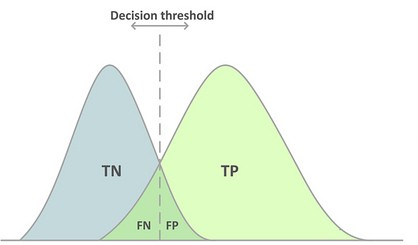
https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

Zunächst werden die Ausgangs-Werte bestimmt.
Anschließend wird die Gewichtung verändert.
1 False Negative verursacht dabei höhere Kosten als x False Positive, wodurch gelernt wird, möglichst keine FN zu erzeugen, damit die Kosten gering bleiben.
Dadurch werden die Ergebnisse "pessimistischer", also es wird eher ein mögliches Risiko ausgegeben.

In [25]:
clf = svm.SVC(kernel="linear", C=optimizer_acc.max["params"].get("C"))
clf.fit(X_train, y_train)

SVC(C=79.5563987218444, kernel='linear')

In [26]:
from sklearn.metrics import confusion_matrix
#Funktion zur Erstellung der Confusion-Matrix
def plot_confusion_matrix(data, suptitle):
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle(suptitle)
    
    _ = sns.heatmap(data, cmap ='binary', annot = True, fmt="d", ax=ax[0]) \
        .set(xlabel = "True label", ylabel = "Predicted label")
    
    _ = sns.heatmap(data / data.sum(), cmap ='binary', annot = True, fmt=".2%", ax=ax[1]) \
        .set(xlabel = "True label", ylabel = "Predicted label")
    
    # Zusammenaddiert für convenience
    float_formatter = "{:.2%}".format
    print("Richtig klassifiziert:", float_formatter((data[0][0] + data[1][1]) / data.sum()))
    print("Falsch klassifiziert:", float_formatter((data[1][0] + data[0][1]) / data.sum()))
    
    plt.show()

SVC(C=79.5563987218444, kernel='linear')
Richtig klassifiziert: 84.14%
Falsch klassifiziert: 15.86%


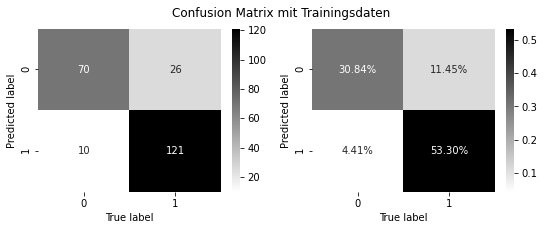

Richtig klassifiziert: 81.58%
Falsch klassifiziert: 18.42%


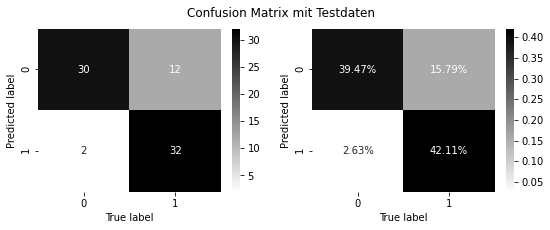

In [27]:
print(clf)
plot_confusion_matrix(confusion_matrix(y_train, clf.predict(X_train)), "Confusion Matrix mit Trainingsdaten")
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(X_test)), "Confusion Matrix mit Testdaten")

### Optimieren

Es wird wie zuvor eine BayesianOptimization angewendet.

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.

def black_box_function(zeroWeight):
    """

    Parameters
    ----------
    zeroWeight: hyper parameter to optimize for
    """
    
    # KI trainieren
    model = svm.SVC(kernel="linear", C=optimizer_acc.max["params"].get("C"), class_weight={0: zeroWeight, 1: 1})
    model.fit(X_train, y_train)
    
    matrix = confusion_matrix(y_train, model.predict(X_train))
    
    true_negative = matrix[0][0]
    true_positive = matrix[1][1]
    false_negative = matrix[0][1]
    false_negative_relative = false_negative / matrix.sum()
    accuracy = (true_positive + true_negative) / matrix.sum()
    
    # accuracy wird mit berücksichtigt, um zu verhindern, 
    # dass alle Herzpatienten sind und ein guter Grundwert der Accuracy bestehen bleibt
    gewichtung = .5 # getestet, liefert gute Ergebnisse
    f = gewichtung * accuracy + (1 - gewichtung) * (1 - false_negative_relative) # Gegenwert zur 1, weil maximiert wird
    return f

# Set range of zeroWeight to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"zeroWeight": [1, 5]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer_weight = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2
                                 )
optimizer_weight.maximize(init_points = 10, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer_weight.max["params"], optimizer_weight.max["target"]))

|   iter    |  target   | zeroWe... |
-------------------------------------
|  1        |  0.8833   |  4.767    |
|  2        |  0.8767   |  1.791    |
|  3        |  0.8678   |  2.223    |
|  4        |  0.8899   |  4.168    |
|  5        |  0.8943   |  3.995    |
|  6        |  0.8921   |  4.229    |
|  7        |  0.8921   |  3.891    |
|  8        |  0.8722   |  1.929    |
|  9        |  0.8899   |  3.161    |
|  10       |  0.8899   |  3.639    |
|  11       |  0.8921   |  4.458    |
|  12       |  0.8634   |  1.0      |
|  13       |  0.8789   |  2.823    |
|  14       |  0.8899   |  3.391    |
|  15       |  0.8921   |  4.005    |
|  16       |  0.8943   |  4.349    |
|  17       |  0.8722   |  1.432    |
|  18       |  0.8943   |  3.995    |
|  19       |  0.8855   |  4.999    |
|  20       |  0.8899   |  3.516    |
Best result: {'zeroWeight': 3.9950422804483656}; f(x) = 0.894273127753304.


In [29]:
clf = svm.SVC(C = optimizer_acc.max["params"].get("C"), kernel = "linear", class_weight={0: optimizer_weight.max["params"].get("zeroWeight"), 1: 1})
clf.fit(data, output)

SVC(C=79.5563987218444, class_weight={0: 3.9950422804483656, 1: 1},
    kernel='linear')

Richtig klassifiziert: 74.45%
Falsch klassifiziert: 25.55%


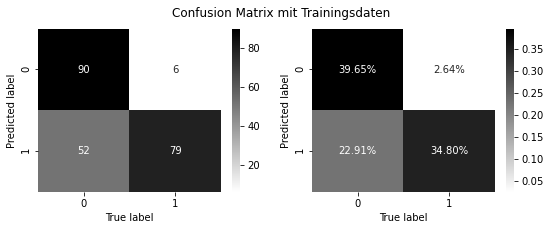

Richtig klassifiziert: 82.89%
Falsch klassifiziert: 17.11%


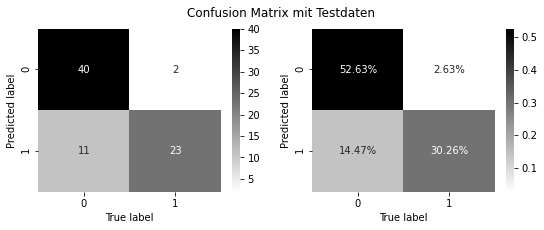

In [30]:
plot_confusion_matrix(confusion_matrix(y_train, clf.predict(X_train)), "Confusion Matrix mit Trainingsdaten")
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(X_test)), "Confusion Matrix mit Testdaten")

Es ist erkennbar, dass es weniger False Negatives gibt, aber dafür mehr False Positives.

Anschließend wird eine erneute Cross-Validation durchgeführt, um die Güte des finalen Models zu prüfen.
Durch die Gewichtung ist eine leichte "Verschlechterung" der Accuracy im Vergleich zu vorher zu erkennen, aber dies wird in Kauf genommen.

In [31]:
#Ermittlung der Accuracy des finalen Modells
k=10
model = svm.SVC(C = optimizer_acc.max["params"].get("C"), kernel = "linear", class_weight={0: optimizer_weight.max["params"].get("zeroWeight"), 1: 1})
model.fit(X_train, y_train)
scores = cross_val_score(model, data, output, cv=k)
scores.mean()

0.7390322580645161

# 5. Evaluation
Da für diese Challenge keine Zielvorgabe existiert, müssen die erzielten Ergebnisse mit den Anforderungen eines realen Anwendungsfalls verglichen werden. Bezogen auf den Anwendungsfall der Medizin sind diese Zahlen keineswegs ausreichend, um in einer realen Situation genutzt werden zu können. Die Genauigkeit unseres Modells stellt für die Vorhersage eines möglichen Herzinfarkts dennoch eine anfängliche Grundlage dar und nähert sich in etwa den Zahlen der Studien, in denen Ärzten ebenfalls nur eine Zuverlässigkeit von 80-90% zugeschrieben wird. Aber das Problem ist in diesem Fall nicht die Genauigkeit selbst, sondern das Risiko der falschen Einordnung einer Person als false negativ. Dies würde bedeuten, dass eine Person mit erhöhtem Herzinfarktrisiko fälschlicherweise unbehandelt bleibt. Das Risiko für dieses Szenario ist zwar nach der durchgeführten BayesianOptimization, wie in der Confusion Matrix zu sehen, sehr gering, ist aber unserer Meinung nach für dieses Szenario noch immer zu hoch. Eine Mensch würde in dieser Abwägung vorsichtiger sein und eher eine weitere Untersuchung veranlassen, ohne sich direkt für eine Klassifizierung entscheiden zu müssen. Genau wie bei einer Ärztlichen Analyse sollte also auch zu dem Ergebnis unserer KI stets eine zweite Meinung eingeholt werden. Dabei kann die KI als Entscheidungsgrundlage fungieren.

Im Nachfolgenden könnten weitere Verfahren, wie z.B. diverse Baumverfahren, genutzt werden. Alle Verfahren könnten dann mittels einer Boosting-Methode unterschiedlich gewichtet werden, um noch bessere Ergebnisse, z.B. in der Accuracy, zu erzielen.